In [32]:
import numpy as np
import pandas as pd

#Data Source
import yfinance as yf

#Data viz
import plotly.graph_objs as go

#Interval required 5 minutes
df = yf.download(tickers='UBER', period='3y', interval='1d')
#Print data
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-05-10,42.000000,45.000000,41.060001,41.570000,41.570000,186322500
2019-05-13,38.790001,39.240002,36.080002,37.099998,37.099998,79442400
2019-05-14,38.310001,39.959999,36.849998,39.959999,39.959999,46661100
2019-05-15,39.369999,41.880001,38.950001,41.290001,41.290001,36086100
2019-05-16,41.480000,44.060001,41.250000,43.000000,43.000000,38115500
...,...,...,...,...,...,...
2021-04-21,55.000000,56.200001,54.610001,55.770000,55.770000,11523900
2021-04-22,55.849998,57.219002,55.189999,56.279999,56.279999,16936200
2021-04-23,56.560001,57.950001,56.389999,57.930000,57.930000,8758800


In [33]:
%matplotlib inline

import math
import matplotlib
import seaborn as sns
import tensorflow as tf
import time

from datetime import date
from matplotlib import pyplot as plt
from numpy.random import seed
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.utils import plot_model

#### Input params ##################
stk_path = "./data/VTI.csv"
test_size = 0.2                # proportion of dataset to be used as test set
cv_size = 0.2                  # proportion of dataset to be used as cross-validation set

N = 9                          # for feature at day t, we use lags from t-1, t-2, ..., t-N as features. 
                               # initial value before tuning
lstm_units=50                  # lstm param. initial value before tuning.
dropout_prob=0.2                 # lstm param. initial value before tuning.
optimizer='adam'               # lstm param. initial value before tuning.
epochs=1                       # lstm param. initial value before tuning.
batch_size=1                   # lstm param. initial value before tuning.

model_seed = 100

fontsize = 14
ticklabelsize = 14
####################################

# Set seeds to ensure same output results
seed(101)
tf.random.set_seed(model_seed)

In [96]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_x_y(data, N, offset):
    """
    Split data into x (features) and y (target)
    """
    x, y = [], []
    for i in range(offset, len(data)):
        x.append(data[i-N:i])
        y.append(data[i])
    x = np.array(x)
    y = np.array(y)
    
    return x, y

def get_x_scaled_y(data, N, offset):
    """
    Split data into x (features) and y (target)
    We scale x to have mean 0 and std dev 1, and return this.
    We do not scale y here.
    Inputs
        data     : pandas series to extract x and y
        N
        offset
    Outputs
        x_scaled : features used to predict y. Scaled such that each element has mean 0 and std dev 1
        y        : target values. Not scaled
        mu_list  : list of the means. Same length as x_scaled and y
        std_list : list of the std devs. Same length as x_scaled and y
    """
    x_scaled, y, mu_list, std_list = [], [], [], []
    for i in range(offset, len(data)):
        mu_list.append(np.mean(data[i-N:i]))
        std_list.append(np.std(data[i-N:i]))
        x_scaled.append((data[i-N:i]-mu_list[i-offset])/std_list[i-offset])
        y.append(data[i])
    x_scaled = np.array(x_scaled)
    y = np.array(y)
    
    return x_scaled, y, mu_list, std_list

def train_pred_eval_model(x_train_scaled, \
                          y_train_scaled, \
                          x_cv_scaled, \
                          y_cv, \
                          mu_cv_list, \
                          std_cv_list, \
                          lstm_units=50, \
                          dropout_prob=0.5, \
                          optimizer='adam', \
                          epochs=1, \
                          batch_size=1):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use LSTM here.
    Returns rmse, mape and predicted values
    Inputs
        x_train_scaled  : e.g. x_train_scaled.shape=(451, 9, 1). Here we are using the past 9 values to predict the next value
        y_train_scaled  : e.g. y_train_scaled.shape=(451, 1)
        x_cv_scaled     : use this to do predictions 
        y_cv            : actual value of the predictions
        mu_cv_list      : list of the means. Same length as x_scaled and y
        std_cv_list     : list of the std devs. Same length as x_scaled and y 
        lstm_units      : lstm param
        dropout_prob    : lstm param
        optimizer       : lstm param
        epochs          : lstm param
        batch_size      : lstm param
    Outputs
        rmse            : root mean square error
        mape            : mean absolute percentage error
        est             : predictions
    '''
    # Create the LSTM network
    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1],1)))
    model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
    model.add(Dense(1))

    # Compile and fit the LSTM network
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=0)
    
    # Do prediction
    est_scaled = model.predict(df_new)
    est = (est_scaled * np.array(std_cv_list).reshape(-1,1)) + np.array(mu_cv_list).reshape(-1,1)
    
    # Calculate RMSE and MAPE
#     print("x_cv_scaled = " + str(x_cv_scaled))
#     print("est_scaled = " + str(est_scaled))
#     print("est = " + str(est))
    rmse = math.sqrt(mean_squared_error(y_cv, est))
    mape = get_mape(y_cv, est)
    
    return rmse, mape, est

In [35]:
df.reset_index(level=0, inplace=True)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-05-10,42.000000,45.000000,41.060001,41.570000,41.570000,186322500
1,2019-05-13,38.790001,39.240002,36.080002,37.099998,37.099998,79442400
2,2019-05-14,38.310001,39.959999,36.849998,39.959999,39.959999,46661100
3,2019-05-15,39.369999,41.880001,38.950001,41.290001,41.290001,36086100
4,2019-05-16,41.480000,44.060001,41.250000,43.000000,43.000000,38115500


In [36]:
'''#df = pd.read_csv(stk_path, sep = ",")

# Convert Date column to datetime
df.loc[:, 'Datetime'] = pd.to_datetime(df['Datetime'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['datetime'].dt.month

# Sort by datetime
df.sort_values(by='datetime', inplace=True, ascending=True)

df.head()'''

'#df = pd.read_csv(stk_path, sep = ",")\n\n# Convert Date column to datetime\ndf.loc[:, \'Datetime\'] = pd.to_datetime(df[\'Datetime\'],format=\'%Y-%m-%d\')\n\n# Change all column headings to be lower case, and remove spacing\ndf.columns = [str(x).lower().replace(\' \', \'_\') for x in df.columns]\n\n# Get month of each sample\ndf[\'month\'] = df[\'datetime\'].dt.month\n\n# Sort by datetime\ndf.sort_values(by=\'datetime\', inplace=True, ascending=True)\n\ndf.head()'

In [37]:
#df = pd.read_csv(stk_path, sep = ",")

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head()

,date,open,high,low,close,adj_close,volume,month
0,2019-05-10,42.000000,45.000000,41.060001,41.570000,41.570000,186322500,5
1,2019-05-13,38.790001,39.240002,36.080002,37.099998,37.099998,79442400,5
2,2019-05-14,38.310001,39.959999,36.849998,39.959999,39.959999,46661100,5
3,2019-05-15,39.369999,41.880001,38.950001,41.290001,41.290001,36086100,5
4,2019-05-16,41.480000,44.060001,41.250000,43.000000,43.000000,38115500,5


In [38]:
#df['date']=df['datetime']

In [39]:
#df.head()

In [40]:
#for i in range(len(df.index)):
#    df['date'][i]=str(df['datetime'][i])[0:10]

In [41]:
#df.head()

Text(0, 0.5, 'USD')

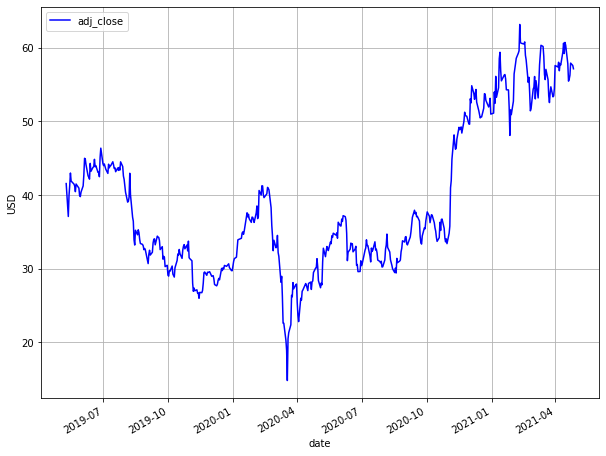

In [42]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [43]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train][['date', 'adj_close']]
cv = df[num_train:num_train+num_cv][['date', 'adj_close']]
train_cv = df[:num_train+num_cv][['date', 'adj_close']]
test = df[num_train+num_cv:][['date', 'adj_close']]

print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 297
num_cv = 99
num_test = 99
train.shape = (297, 2)
cv.shape = (99, 2)
train_cv.shape = (396, 2)
test.shape = (99, 2)


In [44]:

# Converting dataset into x_train and y_train
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(np.array(train['adj_close']).reshape(-1,1))
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))

# Split into x and y
x_train_scaled, y_train_scaled = get_x_y(train_scaled, N, N)
print("x_train_scaled.shape = " + str(x_train_scaled.shape)) # (446, 7, 1)
print("y_train_scaled.shape = " + str(y_train_scaled.shape)) # (446, 1)

scaler.mean_ = [33.95848492]
scaler.var_ = [34.94611954]
x_train_scaled.shape = (288, 9, 1)
y_train_scaled.shape = (288, 1)


In [45]:
# Scale the cv dataset
# Split into x and y
x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_x_scaled_y(np.array(train_cv['adj_close']).reshape(-1,1), N, num_train)
print("x_cv_scaled.shape = " + str(x_cv_scaled.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("len(mu_cv_list) = " + str(len(mu_cv_list)))
print("len(std_cv_list) = " + str(len(std_cv_list)))

x_cv_scaled.shape = (99, 9, 1)
y_cv.shape = (99, 1)
len(mu_cv_list) = 99
len(std_cv_list) = 99


In [98]:
x_cv_scaled

array([[[-1.45508081e+00],
        [-1.24317582e+00],
        [ 3.16445018e-01],
        [ 5.70730356e-01],
        [ 1.51158902e+00],
        [ 8.50446492e-01],
        [ 8.41968481e-01],
        [-3.61651911e-01],
        [-1.03127083e+00]],

       [[-1.69473596e+00],
        [ 1.06601008e-01],
        [ 4.00296480e-01],
        [ 1.48697309e+00],
        [ 7.23364115e-01],
        [ 7.13572149e-01],
        [-6.76590031e-01],
        [-1.44998911e+00],
        [ 3.90508250e-01]],

       [[-9.32186060e-02],
        [ 2.71550659e-01],
        [ 1.62120111e+00],
        [ 6.72800097e-01],
        [ 6.60638493e-01],
        [-1.06594051e+00],
        [-2.02650081e+00],
        [ 2.59393693e-01],
        [-2.99924127e-01]],

       [[ 2.67581346e-01],
        [ 1.61765322e+00],
        [ 6.68956072e-01],
        [ 6.56790671e-01],
        [-1.07032745e+00],
        [-2.03118768e+00],
        [ 2.55420585e-01],
        [-3.04071879e-01],
        [-6.08148914e-02]],

       [[ 1.39424437

In [46]:
# Here we scale the train_cv set, for the final model
scaler_final = StandardScaler()
train_cv_scaled_final = scaler_final.fit_transform(np.array(train_cv['adj_close']).reshape(-1,1))
x_train_cv_scaled, y_train_cv_scaled = get_x_y(train_cv_scaled_final, N, N)

print("scaler_final.mean_ = " + str(scaler_final.mean_))
print("scaler_final.var_ = " + str(scaler_final.var_))

# # Scale the test dataset
x_test_scaled, y_test, mu_test_list, std_test_list = get_x_scaled_y(np.array(df['adj_close']).reshape(-1,1), N, num_train+num_cv)
print("x_test_scaled.shape = " + str(x_test_scaled.shape))
print("y_test.shape = " + str(y_test.shape))
print("len(mu_test_list) = " + str(len(mu_test_list)))
print("len(std_test_list) = " + str(len(std_test_list)))

scaler_final.mean_ = [34.66507582]
scaler_final.var_ = [37.42176459]
x_test_scaled.shape = (99, 9, 1)
y_test.shape = (99, 1)
len(mu_test_list) = 99
len(std_test_list) = 99


In [47]:

# Create the LSTM network
model = Sequential()
model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1],1)))
model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
model.add(LSTM(units=lstm_units))
model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=optimizer)
model.fit(x_train_scaled,y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=2)

288/288 - 3s - loss: 0.2098


In [48]:
# Do prediction
est_scaled = model.predict(x_cv_scaled)
est = (est_scaled * np.array(std_cv_list).reshape(-1,1)) + np.array(mu_cv_list).reshape(-1,1)
print("est.shape = " + str(est.shape))

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, est))
print("RMSE = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_pct_bef_tuning = get_mape(y_cv, est)
print("MAPE = %0.3f%%" % mape_pct_bef_tuning)

est.shape = (99, 1)
RMSE = 2.610
MAPE = 4.856%


Text(0, 0.5, 'USD')

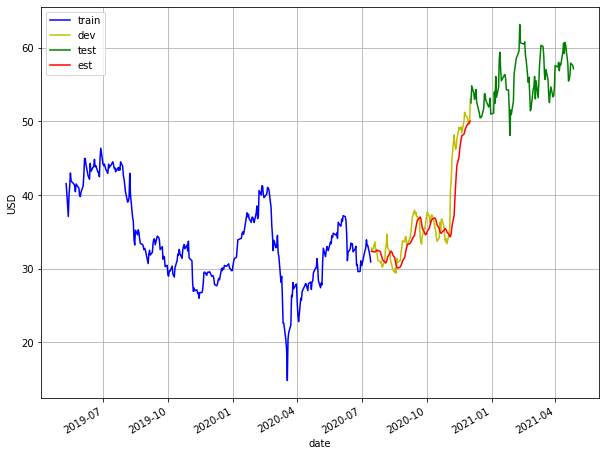

In [49]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est.reshape(-1), 
                       'y_cv': y_cv.reshape(-1),
                       'date': cv['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'est'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [97]:

rmse, mape, est = train_pred_eval_model(x_train_cv_scaled, \
                                        y_train_cv_scaled, \
                                        x_test_scaled, \
                                        y_test, \
                                        mu_test_list, \
                                        std_test_list, \
                                        lstm_units=lstm_units, \
                                        dropout_prob=dropout_prob, \
                                        optimizer=optimizer, \
                                        epochs=epochs, \
                                        batch_size=batch_size)

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type datetime.date).

In [95]:
listy=[datetime.date.today()]
for i in range(1,30):
    listy.append(datetime.date.today())
print(listy)
df_new = pd.DataFrame(listy, columns = ['date'])

for i in range(1,30):
    df_new['date'][i]= df_new['date'][i-1] + datetime.timedelta(days=1)
df_new

[datetime.date(2021, 4, 28), datetime.date(2021, 4, 28), datetime.date(2021, 4, 28), datetime.date(2021, 4, 28), datetime.date(2021, 4, 28), datetime.date(2021, 4, 28), datetime.date(2021, 4, 28), datetime.date(2021, 4, 28), datetime.date(2021, 4, 28), datetime.date(2021, 4, 28), datetime.date(2021, 4, 28), datetime.date(2021, 4, 28), datetime.date(2021, 4, 28), datetime.date(2021, 4, 28), datetime.date(2021, 4, 28), datetime.date(2021, 4, 28), datetime.date(2021, 4, 28), datetime.date(2021, 4, 28), datetime.date(2021, 4, 28), datetime.date(2021, 4, 28), datetime.date(2021, 4, 28), datetime.date(2021, 4, 28), datetime.date(2021, 4, 28), datetime.date(2021, 4, 28), datetime.date(2021, 4, 28), datetime.date(2021, 4, 28), datetime.date(2021, 4, 28), datetime.date(2021, 4, 28), datetime.date(2021, 4, 28), datetime.date(2021, 4, 28)]


,date
0,2021-04-28
1,2021-04-29
2,2021-04-30
3,2021-05-01
4,2021-05-02
5,2021-05-03
6,2021-05-04
7,2021-05-05
8,2021-05-06
9,2021-05-07


In [52]:
df.head()

,date,open,high,low,close,adj_close,volume,month
0,2019-05-10,42.000000,45.000000,41.060001,41.570000,41.570000,186322500,5
1,2019-05-13,38.790001,39.240002,36.080002,37.099998,37.099998,79442400,5
2,2019-05-14,38.310001,39.959999,36.849998,39.959999,39.959999,46661100,5
3,2019-05-15,39.369999,41.880001,38.950001,41.290001,41.290001,36086100,5
4,2019-05-16,41.480000,44.060001,41.250000,43.000000,43.000000,38115500,5


Text(0, 0.5, 'USD')

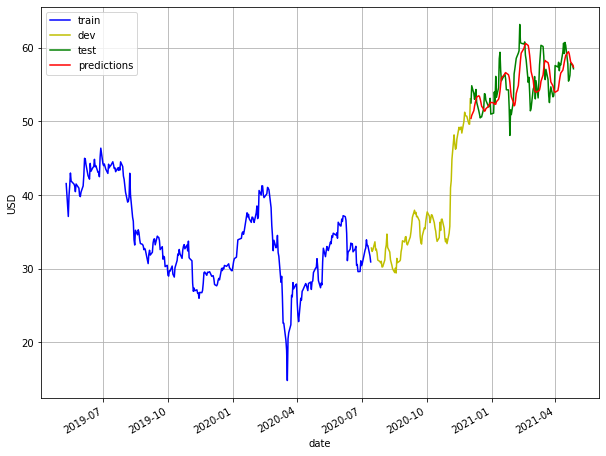

In [25]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est.reshape(-1), 
                       'date': df[num_train+num_cv:]['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

NameError: name 'get_x_scaled_y' is not defined